In [1]:
import os
import time
import copy
import glob
import cv2
import shutil
import pickle
from tqdm import tqdm

import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [2]:
# parameters
batch_size = 128
epoch = 60
label_name = 'bottom'
class_num = 3
result_path = 'result'
folder_name = f'{label_name}_epoch{epoch}_batch{batch_size}'
num_worker = 4

In [3]:
# 모델의 파라미터 학습 유무 설정
def set_parameter_requires_grad(model, feature_extracting= True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = feature_extracting

In [4]:
# 모델 학습 함수
def train_model(model, train_loaders, val_loaders, criterion, optmizer, device, result_path, name, num_epochs= 3):
    since = time.time()
    os.makedirs(f'{result_path}/{name}', exist_ok= True)
    print(f'{result_path}/{name}')
    train_acc_history = []
    train_loss_history = []
    val_acc_history = []
    val_loss_history = []
    best_acc = 0.0

    for epoch in range(num_epochs):
        epoch_start = time.time()
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-'*10)

        train_running_loss = 0.0
        train_running_corrects = 0

        torch.cuda.empty_cache()
        for inputs, labels in tqdm(train_loaders, desc = 'train', mininterval = 0.1):
            inputs = inputs.to(device)
            labels = labels.to(device)

            model.to(device)
            optmizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optmizer.step()

            train_running_loss += loss.item()*inputs.size(0)
            train_running_corrects += torch.sum(preds == labels.data)
        
        train_epoch_loss = train_running_loss / len(train_loaders.dataset)
        train_epoch_acc = train_running_corrects.double() / len(train_loaders.dataset)

        print('train_Loss: {:.4f} train_Acc: {:.4f}'.format(train_epoch_loss, train_epoch_acc))

        if train_epoch_acc > best_acc:
            best_acc = train_epoch_acc

        train_acc_history.append(train_epoch_acc.item())
        train_loss_history.append(train_epoch_loss)

        # validation set
        val_loss = 0.0
        val_corrects = 0
        
        torch.cuda.empty_cache()
        for inputs, labels in tqdm(val_loaders, desc = 'val', mininterval = 0.1):
            inputs = inputs.to(device)
            labels = labels.to(device)

            model.to(device)
            optmizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            #loss.backward()
            #optmizer.step()

            val_loss += loss.item()*inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)        
        
        val_epoch_loss = val_loss / len(val_loaders.dataset)
        val_epoch_acc = val_corrects.double() / len(val_loaders.dataset)

        print('val_Loss: {:.4f} val_Acc: {:.4f}'.format(val_epoch_loss, val_epoch_acc))

        if val_epoch_acc > best_acc:
            best_acc = val_epoch_acc

        val_acc_history.append(val_epoch_acc.item())
        val_loss_history.append(val_epoch_loss)

        # save parameters        
        torch.save(model.state_dict(), f'{result_path}/{name}/{epoch:03}.pth')

        # prin epoch time
        epoch_end = time.time()
        print('epoch time : ', epoch_end - epoch_start)

    time_elapsed = time.time() - since
    print('Training complete in {:0f}m {:0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))

    # acc, loss를 파일로 저장
    train_acc_file_name = f'{result_path}/{name}/train_acc_hist.pkl'
    train_loss_file_name = f'{result_path}/{name}/train_loss_hist.pkl'

    with open(train_acc_file_name, 'wb') as file:
        pickle.dump(train_acc_history, file)
    with open(train_loss_file_name, 'wb') as file:
        pickle.dump(train_loss_history, file)

    val_acc_file_name = f'{result_path}/{name}/val_acc_hist.pkl'
    val_loss_file_name = f'{result_path}/{name}/val_loss_hist.pkl'

    with open(val_acc_file_name, 'wb') as file:
        pickle.dump(val_acc_history, file)
    with open(val_loss_file_name, 'wb') as file:
        pickle.dump(val_loss_history, file)

    return train_acc_history, train_loss_history, val_acc_history, val_loss_history

In [5]:
# train data
train_data_path = f'../dataset/resnet_dataset/{label_name}'

trsf = transforms.Compose([transforms.Resize([224, 224]),
                           #transforms.RandomResizedCrop(224),
                           transforms.RandomHorizontalFlip(),
                           transforms.ToTensor()])

train_dataset = torchvision.datasets.ImageFolder(train_data_path, transform= trsf)
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size= batch_size,
                                           num_workers= num_worker,
                                           shuffle= True)

print('num of train set is', len(train_dataset))

# validation data
val_data_path = f'../dataset/resnet_dataset/{label_name}_test'

trsf = transforms.Compose(
    [
        transforms.Resize([224, 224]),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)

val_dataset = torchvision.datasets.ImageFolder(
    root= val_data_path,
    transform= trsf
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size= batch_size//2,
    num_workers= num_worker,
    shuffle= True
)

print('num of validation set is', len(val_dataset))

num of train set is 16930
num of validation set is 2000


In [6]:
# 사전 훈련된 모델, 파라미터 학습 허용
model_res50 = models.resnet50(pretrained= True)
set_parameter_requires_grad(model_res50, True)

# 완전연결층 추가
model_res50.fc = nn.Linear(2048, class_num)

#print(model_res50)

# 파라미터 값 확인
#for name, param in model_res50.named_parameters():
#    if param.requires_grad:
#        print(name, param.data)

c:\Users\ihman\anaconda3\envs\RPA_proj\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ihman\anaconda3\envs\RPA_proj\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# 학습 결과를 옵티마이저에 전달

params_to_update = []

for name, param in model_res50.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        #print('\t', name)

opt = optim.Adam(params_to_update)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist, val_acc_hist, val_loss_hist = train_model(model_res50, train_loader, val_loader, criterion, opt, device, result_path, folder_name, epoch)
torch.cuda.empty_cache()

result/bottom_epoch60_batch128
Epoch 0/59
----------


train: 100%|██████████| 133/133 [01:47<00:00,  1.24it/s]


train_Loss: 0.2346 train_Acc: 0.9117


val: 100%|██████████| 32/32 [00:15<00:00,  2.06it/s]


val_Loss: 0.2409 val_Acc: 0.9085
epoch time :  122.75128126144409
Epoch 1/59
----------


train: 100%|██████████| 133/133 [01:46<00:00,  1.25it/s]


train_Loss: 0.1438 train_Acc: 0.9484


val: 100%|██████████| 32/32 [00:15<00:00,  2.03it/s]


val_Loss: 0.2989 val_Acc: 0.8980
epoch time :  122.23328518867493
Epoch 2/59
----------


train: 100%|██████████| 133/133 [01:49<00:00,  1.21it/s]


train_Loss: 0.1237 train_Acc: 0.9549


val: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]


val_Loss: 0.1932 val_Acc: 0.9380
epoch time :  124.7488055229187
Epoch 3/59
----------


train: 100%|██████████| 133/133 [01:48<00:00,  1.22it/s]


train_Loss: 0.1042 train_Acc: 0.9630


val: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]


val_Loss: 0.1671 val_Acc: 0.9405
epoch time :  123.92829704284668
Epoch 4/59
----------


train: 100%|██████████| 133/133 [01:48<00:00,  1.23it/s]


train_Loss: 0.0884 train_Acc: 0.9691


val: 100%|██████████| 32/32 [00:15<00:00,  2.13it/s]


val_Loss: 0.1300 val_Acc: 0.9580
epoch time :  123.59725999832153
Epoch 5/59
----------


train: 100%|██████████| 133/133 [01:48<00:00,  1.23it/s]


train_Loss: 0.0801 train_Acc: 0.9719


val: 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]


val_Loss: 0.1643 val_Acc: 0.9430
epoch time :  123.74814534187317
Epoch 6/59
----------


train: 100%|██████████| 133/133 [01:48<00:00,  1.22it/s]


train_Loss: 0.0669 train_Acc: 0.9760


val: 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]


val_Loss: 0.1629 val_Acc: 0.9420
epoch time :  123.761155128479
Epoch 7/59
----------


train: 100%|██████████| 133/133 [01:48<00:00,  1.23it/s]


train_Loss: 0.0616 train_Acc: 0.9793


val: 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]


val_Loss: 0.1793 val_Acc: 0.9515
epoch time :  123.36311554908752
Epoch 8/59
----------


train: 100%|██████████| 133/133 [01:48<00:00,  1.23it/s]


train_Loss: 0.0655 train_Acc: 0.9766


val: 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]


val_Loss: 0.1389 val_Acc: 0.9545
epoch time :  123.56216979026794
Epoch 9/59
----------


train: 100%|██████████| 133/133 [01:48<00:00,  1.23it/s]


train_Loss: 0.0511 train_Acc: 0.9817


val: 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]


val_Loss: 0.2078 val_Acc: 0.9430
epoch time :  123.56741881370544
Epoch 10/59
----------


train: 100%|██████████| 133/133 [01:48<00:00,  1.23it/s]


train_Loss: 0.0636 train_Acc: 0.9774


val: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]


val_Loss: 0.1828 val_Acc: 0.9395
epoch time :  123.54603338241577
Epoch 11/59
----------


train: 100%|██████████| 133/133 [01:48<00:00,  1.23it/s]


train_Loss: 0.0369 train_Acc: 0.9866


val: 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]


val_Loss: 0.1701 val_Acc: 0.9485
epoch time :  123.56409120559692
Epoch 12/59
----------


train: 100%|██████████| 133/133 [01:48<00:00,  1.23it/s]


train_Loss: 0.0470 train_Acc: 0.9838


val: 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]


val_Loss: 0.1973 val_Acc: 0.9405
epoch time :  123.55898427963257
Epoch 13/59
----------


train: 100%|██████████| 133/133 [01:48<00:00,  1.23it/s]


train_Loss: 0.0411 train_Acc: 0.9851


val: 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]


val_Loss: 0.1615 val_Acc: 0.9585
epoch time :  123.55330395698547
Epoch 14/59
----------


train: 100%|██████████| 133/133 [01:48<00:00,  1.23it/s]


train_Loss: 0.0425 train_Acc: 0.9845


val: 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]


val_Loss: 0.2301 val_Acc: 0.9460
epoch time :  123.59024167060852
Epoch 15/59
----------


train: 100%|██████████| 133/133 [01:48<00:00,  1.23it/s]


train_Loss: 0.0456 train_Acc: 0.9840


val: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]


val_Loss: 0.2000 val_Acc: 0.9430
epoch time :  123.5659875869751
Epoch 16/59
----------


train: 100%|██████████| 133/133 [01:48<00:00,  1.22it/s]


train_Loss: 0.0301 train_Acc: 0.9894


val: 100%|██████████| 32/32 [00:15<00:00,  2.13it/s]


val_Loss: 0.2707 val_Acc: 0.9315
epoch time :  123.9781289100647
Epoch 17/59
----------


train: 100%|██████████| 133/133 [01:49<00:00,  1.21it/s]


train_Loss: 0.0245 train_Acc: 0.9923


val: 100%|██████████| 32/32 [00:15<00:00,  2.11it/s]


val_Loss: 0.1558 val_Acc: 0.9605
epoch time :  124.91459012031555
Epoch 18/59
----------


train: 100%|██████████| 133/133 [01:48<00:00,  1.23it/s]


train_Loss: 0.0245 train_Acc: 0.9918


val: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]


val_Loss: 0.2422 val_Acc: 0.9400
epoch time :  123.58486008644104
Epoch 19/59
----------


train: 100%|██████████| 133/133 [01:48<00:00,  1.23it/s]


train_Loss: 0.0313 train_Acc: 0.9892


val: 100%|██████████| 32/32 [00:15<00:00,  2.13it/s]


val_Loss: 0.2236 val_Acc: 0.9430
epoch time :  123.75128507614136
Epoch 20/59
----------


train: 100%|██████████| 133/133 [01:48<00:00,  1.23it/s]


train_Loss: 0.0357 train_Acc: 0.9874


val: 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]


val_Loss: 0.1762 val_Acc: 0.9535
epoch time :  123.56794953346252
Epoch 21/59
----------


train: 100%|██████████| 133/133 [01:48<00:00,  1.23it/s]


train_Loss: 0.0208 train_Acc: 0.9927


val: 100%|██████████| 32/32 [00:14<00:00,  2.17it/s]


val_Loss: 0.3072 val_Acc: 0.9370
epoch time :  123.35251069068909
Epoch 22/59
----------


train: 100%|██████████| 133/133 [01:48<00:00,  1.23it/s]


train_Loss: 0.0276 train_Acc: 0.9900


val: 100%|██████████| 32/32 [00:14<00:00,  2.19it/s]


val_Loss: 0.3430 val_Acc: 0.9250
epoch time :  123.17133831977844
Epoch 23/59
----------


train: 100%|██████████| 133/133 [01:48<00:00,  1.23it/s]


train_Loss: 0.0270 train_Acc: 0.9905


val: 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]


val_Loss: 0.2543 val_Acc: 0.9335
epoch time :  123.55056381225586
Epoch 24/59
----------


train: 100%|██████████| 133/133 [01:48<00:00,  1.23it/s]


train_Loss: 0.0233 train_Acc: 0.9921


val: 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]


val_Loss: 0.2090 val_Acc: 0.9475
epoch time :  123.53713607788086
Epoch 25/59
----------


train: 100%|██████████| 133/133 [01:44<00:00,  1.28it/s]


train_Loss: 0.0224 train_Acc: 0.9918


val: 100%|██████████| 32/32 [00:13<00:00,  2.30it/s]


val_Loss: 0.2425 val_Acc: 0.9415
epoch time :  118.31222796440125
Epoch 26/59
----------


train: 100%|██████████| 133/133 [01:39<00:00,  1.34it/s]


train_Loss: 0.0209 train_Acc: 0.9927


val: 100%|██████████| 32/32 [00:14<00:00,  2.27it/s]


val_Loss: 0.2298 val_Acc: 0.9435
epoch time :  113.65471005439758
Epoch 27/59
----------


train: 100%|██████████| 133/133 [01:45<00:00,  1.26it/s]


train_Loss: 0.0178 train_Acc: 0.9939


val: 100%|██████████| 32/32 [00:15<00:00,  2.11it/s]


val_Loss: 0.2280 val_Acc: 0.9495
epoch time :  121.27898478507996
Epoch 28/59
----------


train: 100%|██████████| 133/133 [01:49<00:00,  1.21it/s]


train_Loss: 0.0175 train_Acc: 0.9942


val: 100%|██████████| 32/32 [00:15<00:00,  2.10it/s]


val_Loss: 0.1849 val_Acc: 0.9595
epoch time :  125.2201817035675
Epoch 29/59
----------


train: 100%|██████████| 133/133 [01:50<00:00,  1.21it/s]


train_Loss: 0.0237 train_Acc: 0.9916


val: 100%|██████████| 32/32 [00:14<00:00,  2.19it/s]


val_Loss: 0.1748 val_Acc: 0.9555
epoch time :  125.0958251953125
Epoch 30/59
----------


train: 100%|██████████| 133/133 [01:46<00:00,  1.25it/s]


train_Loss: 0.0352 train_Acc: 0.9874


val: 100%|██████████| 32/32 [00:14<00:00,  2.19it/s]


val_Loss: 0.2686 val_Acc: 0.9365
epoch time :  121.34392046928406
Epoch 31/59
----------


train: 100%|██████████| 133/133 [01:38<00:00,  1.34it/s]


train_Loss: 0.0123 train_Acc: 0.9956


val: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]


val_Loss: 0.2396 val_Acc: 0.9480
epoch time :  112.96003222465515
Epoch 32/59
----------


train: 100%|██████████| 133/133 [01:37<00:00,  1.36it/s]


train_Loss: 0.0094 train_Acc: 0.9968


val: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]


val_Loss: 0.2952 val_Acc: 0.9395
epoch time :  111.3610451221466
Epoch 33/59
----------


train: 100%|██████████| 133/133 [01:37<00:00,  1.36it/s]


train_Loss: 0.0195 train_Acc: 0.9932


val: 100%|██████████| 32/32 [00:14<00:00,  2.25it/s]


val_Loss: 0.2244 val_Acc: 0.9470
epoch time :  111.98844885826111
Epoch 34/59
----------


train: 100%|██████████| 133/133 [01:38<00:00,  1.35it/s]


train_Loss: 0.0178 train_Acc: 0.9936


val: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]


val_Loss: 0.1903 val_Acc: 0.9560
epoch time :  112.16195750236511
Epoch 35/59
----------


train: 100%|██████████| 133/133 [01:37<00:00,  1.36it/s]


train_Loss: 0.0096 train_Acc: 0.9966


val: 100%|██████████| 32/32 [00:13<00:00,  2.36it/s]


val_Loss: 0.2731 val_Acc: 0.9395
epoch time :  111.5136067867279
Epoch 36/59
----------


train: 100%|██████████| 133/133 [01:37<00:00,  1.36it/s]


train_Loss: 0.0299 train_Acc: 0.9891


val: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]


val_Loss: 0.2004 val_Acc: 0.9525
epoch time :  111.76693081855774
Epoch 37/59
----------


train: 100%|██████████| 133/133 [01:37<00:00,  1.36it/s]


train_Loss: 0.0180 train_Acc: 0.9938


val: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]


val_Loss: 0.2270 val_Acc: 0.9580
epoch time :  111.59934186935425
Epoch 38/59
----------


train: 100%|██████████| 133/133 [01:38<00:00,  1.35it/s]


train_Loss: 0.0136 train_Acc: 0.9950


val: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]


val_Loss: 0.2166 val_Acc: 0.9575
epoch time :  112.33004188537598
Epoch 39/59
----------


train: 100%|██████████| 133/133 [01:37<00:00,  1.36it/s]


train_Loss: 0.0189 train_Acc: 0.9931


val: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]


val_Loss: 0.2603 val_Acc: 0.9450
epoch time :  111.3860251903534
Epoch 40/59
----------


train: 100%|██████████| 133/133 [01:37<00:00,  1.36it/s]


train_Loss: 0.0126 train_Acc: 0.9957


val: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]


val_Loss: 0.2614 val_Acc: 0.9505
epoch time :  111.53436827659607
Epoch 41/59
----------


train: 100%|██████████| 133/133 [01:37<00:00,  1.36it/s]


train_Loss: 0.0237 train_Acc: 0.9913


val: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]


val_Loss: 0.2056 val_Acc: 0.9600
epoch time :  111.37299585342407
Epoch 42/59
----------


train: 100%|██████████| 133/133 [01:37<00:00,  1.36it/s]


train_Loss: 0.0105 train_Acc: 0.9968


val: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]


val_Loss: 0.2698 val_Acc: 0.9455
epoch time :  111.58077788352966
Epoch 43/59
----------


train: 100%|██████████| 133/133 [01:37<00:00,  1.36it/s]


train_Loss: 0.0092 train_Acc: 0.9969


val: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]


val_Loss: 0.2619 val_Acc: 0.9460
epoch time :  111.5343668460846
Epoch 44/59
----------


train: 100%|██████████| 133/133 [01:37<00:00,  1.36it/s]


train_Loss: 0.0114 train_Acc: 0.9963


val: 100%|██████████| 32/32 [00:13<00:00,  2.36it/s]


val_Loss: 0.2034 val_Acc: 0.9660
epoch time :  111.3634078502655
Epoch 45/59
----------


train: 100%|██████████| 133/133 [01:37<00:00,  1.36it/s]


train_Loss: 0.0125 train_Acc: 0.9962


val: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]


val_Loss: 0.2953 val_Acc: 0.9435
epoch time :  111.39294958114624
Epoch 46/59
----------


train: 100%|██████████| 133/133 [01:37<00:00,  1.36it/s]


train_Loss: 0.0090 train_Acc: 0.9966


val: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]


val_Loss: 0.3882 val_Acc: 0.9250
epoch time :  111.55476951599121
Epoch 47/59
----------


train: 100%|██████████| 133/133 [01:37<00:00,  1.36it/s]


train_Loss: 0.0142 train_Acc: 0.9953


val: 100%|██████████| 32/32 [00:13<00:00,  2.34it/s]


val_Loss: 0.2680 val_Acc: 0.9445
epoch time :  111.55610275268555
Epoch 48/59
----------


train: 100%|██████████| 133/133 [01:37<00:00,  1.36it/s]


train_Loss: 0.0147 train_Acc: 0.9948


val: 100%|██████████| 32/32 [00:13<00:00,  2.34it/s]


val_Loss: 0.2054 val_Acc: 0.9555
epoch time :  111.38127946853638
Epoch 49/59
----------


train: 100%|██████████| 133/133 [01:37<00:00,  1.37it/s]


train_Loss: 0.0167 train_Acc: 0.9947


val: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]


val_Loss: 0.1949 val_Acc: 0.9540
epoch time :  111.33530282974243
Epoch 50/59
----------


train: 100%|██████████| 133/133 [01:37<00:00,  1.36it/s]


train_Loss: 0.0132 train_Acc: 0.9953


val: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]


val_Loss: 0.1599 val_Acc: 0.9625
epoch time :  111.38321542739868
Epoch 51/59
----------


train: 100%|██████████| 133/133 [01:37<00:00,  1.36it/s]


train_Loss: 0.0148 train_Acc: 0.9948


val: 100%|██████████| 32/32 [00:13<00:00,  2.34it/s]


val_Loss: 0.2323 val_Acc: 0.9580
epoch time :  111.56491780281067
Epoch 52/59
----------


train: 100%|██████████| 133/133 [01:37<00:00,  1.36it/s]


train_Loss: 0.0101 train_Acc: 0.9965


val: 100%|██████████| 32/32 [00:13<00:00,  2.34it/s]


val_Loss: 0.2510 val_Acc: 0.9545
epoch time :  111.53708148002625
Epoch 53/59
----------


train: 100%|██████████| 133/133 [01:37<00:00,  1.37it/s]


train_Loss: 0.0094 train_Acc: 0.9967


val: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]


val_Loss: 0.2444 val_Acc: 0.9440
epoch time :  111.39445352554321
Epoch 54/59
----------


train: 100%|██████████| 133/133 [01:37<00:00,  1.37it/s]


train_Loss: 0.0062 train_Acc: 0.9979


val: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]


val_Loss: 0.2403 val_Acc: 0.9510
epoch time :  111.35069823265076
Epoch 55/59
----------


train: 100%|██████████| 133/133 [01:37<00:00,  1.37it/s]


train_Loss: 0.0076 train_Acc: 0.9975


val: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]


val_Loss: 0.2234 val_Acc: 0.9570
epoch time :  111.39722776412964
Epoch 56/59
----------


train: 100%|██████████| 133/133 [01:37<00:00,  1.36it/s]


train_Loss: 0.0128 train_Acc: 0.9951


val: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]


val_Loss: 0.2598 val_Acc: 0.9525
epoch time :  111.54123711585999
Epoch 57/59
----------


train: 100%|██████████| 133/133 [01:37<00:00,  1.36it/s]


train_Loss: 0.0114 train_Acc: 0.9960


val: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]


val_Loss: 0.3208 val_Acc: 0.9395
epoch time :  111.76641464233398
Epoch 58/59
----------


train: 100%|██████████| 133/133 [01:37<00:00,  1.36it/s]


train_Loss: 0.0075 train_Acc: 0.9976


val: 100%|██████████| 32/32 [00:13<00:00,  2.34it/s]


val_Loss: 0.2763 val_Acc: 0.9505
epoch time :  111.58543467521667
Epoch 59/59
----------


train: 100%|██████████| 133/133 [01:37<00:00,  1.36it/s]


train_Loss: 0.0131 train_Acc: 0.9955


val: 100%|██████████| 32/32 [00:13<00:00,  2.34it/s]

val_Loss: 0.2851 val_Acc: 0.9470
epoch time :  111.58944416046143
Training complete in 117.000000m 31.739666s
Best Acc: 0.997933


In [9]:
# 테스트 데이터 평가 함수

def eval_model(model, dataloaders, device, n):
    since = time.time()
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob(f'{result_path}/{folder_name}/*.pth')
    saved_models.sort()
    print('saved_model', saved_models)

    for model_path in saved_models[-n:]:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path, map_location= device))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)
            #print(preds)
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0
            if device == 'cpu':
                running_corrects += preds.eq(labels.cpu()).int().sum()
            else:
                running_corrects += preds.eq(labels.cuda()).int().sum()

        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print(f'Acc: {epoch_acc}')

        if epoch_acc > best_acc:
            best_acc = epoch_acc
        
        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print(f'Val complete in {time_elapsed // 60}m {time_elapsed * 60}s')
    print(f'Best Acc: {best_acc}')

    return acc_history

In [10]:
# 평가
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
weight_path = f'{result_path}/{folder_name}/{epoch-1:03}.pth'
model_dict = torch.load(weight_path, map_location= device)
model_res50.load_state_dict(model_dict)

C:\Users\ihman\AppData\Local\Temp\ipykernel_19588\3343858902.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = torch.load(weight_path, map_location= device)


cuda


<All keys matched successfully>

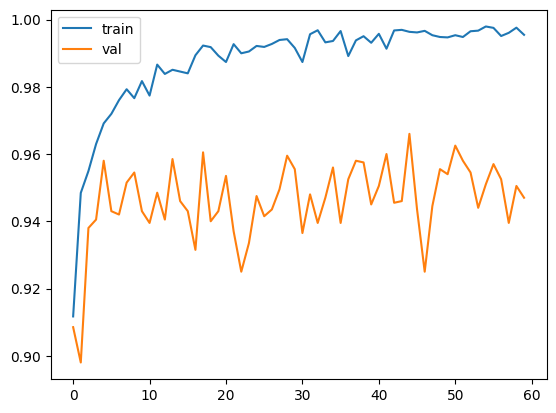

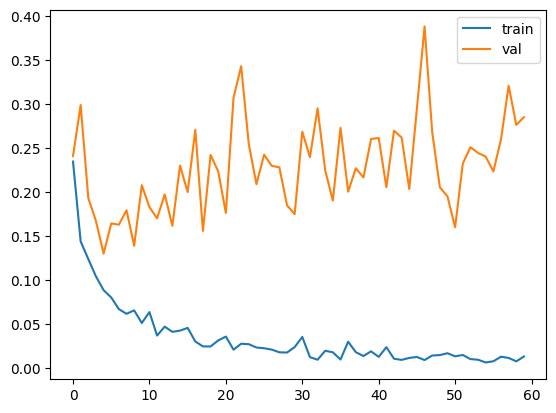

In [15]:
plt.plot(train_acc_hist, label= 'train')
plt.plot(val_acc_hist, label= 'val')
plt.legend()
plt.show()

plt.plot(train_loss_hist, label= 'train')
plt.plot(val_loss_hist, label= 'val')
plt.legend()
plt.show()

In [12]:
# 예측 이미지 출력을 위한 전처리 함수

def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    # clone() : 기존 텐서의 내용을 복사
    # detach() : 기존 텐서에서 기울기가 전파되지 않는 텐서
    image = image.transpose(1, 2, 0)
    image = image*(np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)))
    image = image.clip(0, 1)

    return image

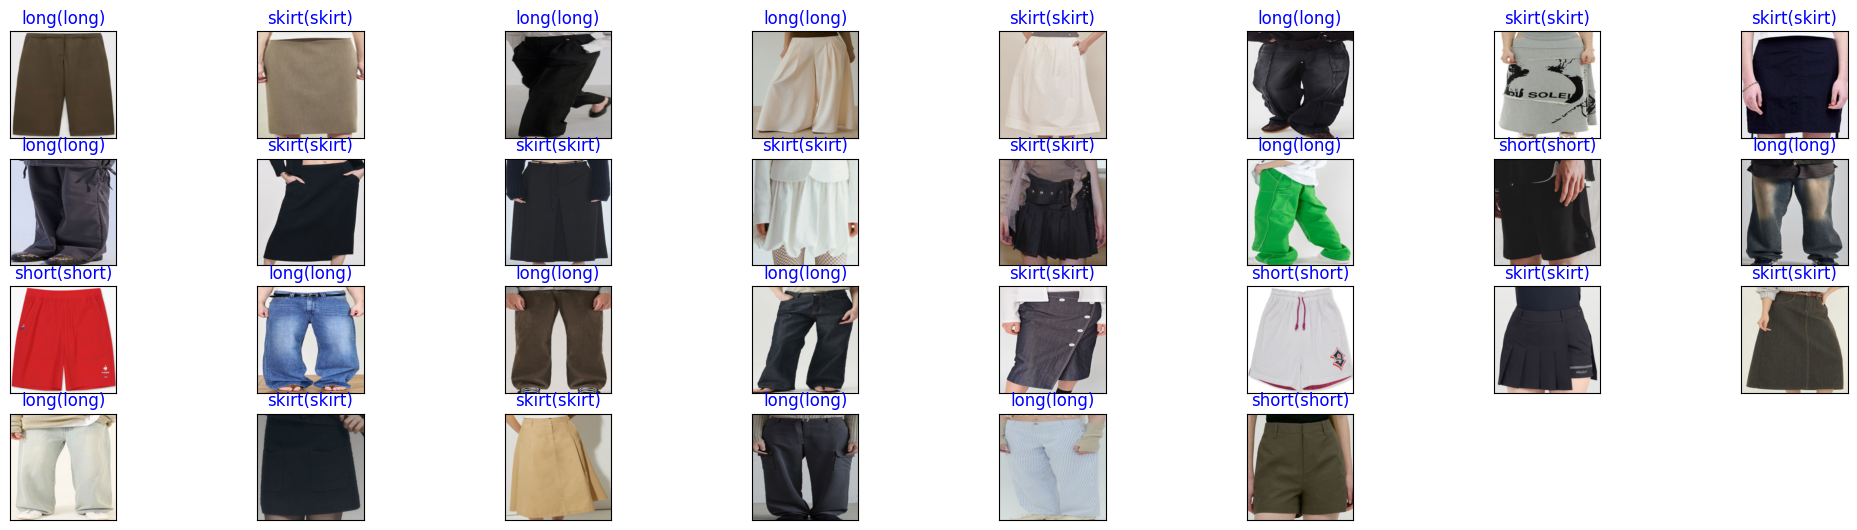

<Figure size 640x480 with 0 Axes>

In [16]:
# 예측 결과 출력

classes = {0 : 'long', 1 : 'shorts', 2 : 'skirt'}

dataiter = iter(val_loader)
images, labels = next(dataiter)
model_res50 = model_res50.to('cpu')
output = model_res50(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize= (25, 8))
for idx in np.arange(30):
    ax = fig.add_subplot(5, 8, idx + 1, xticks= [], yticks= [])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])
    ax.set_title(f'{classes[preds[idx].item()][:5]}({classes[labels[idx].item()][:5]})', color= ('blue' if preds[idx] == labels[idx] else 'red'))
    # 일치하면 green, 불일치하면 red

plt.show()
plt.subplots_adjust(bottom= 0.2, top= 0.6, hspace= 0)